# Model selection using information criteria

author: Audrey Olivier

Theory background: model selection refers to the task of selecting a statistical model from a set of candidate models, given some data. A good model is amodel that is able to explain the data well (high model evidence). Given models of same explanatory power, the simplest model should be chosen (Ockam razor). Several simple criteria can be used to compute a model's quality and thus perform model selection. UQpy implements three citeria: 
<br>
Bayesian information criterion (BIC)
$$ BIC = ln(n) k - 2 ln(\hat{L}) $$

Akaike information criterion (AIC)
$$ AIC = 2 k - 2 ln (\hat{L})  $$

Corrected formula for AIC (AICc), for small data sets 
$$ AICc = AIC + \frac{2k(k+1)}{n-k-1} $$

For all formula above, $k$ is the number of parameters characterizing the model, $\hat{L}$ is the maximum value of the likelihood function and $n$ the number of data points. The best model is the one that minimizes the cirterion. All three formulas have a model fit term (find the model that minimizes the negative log likelihood) and a penalty term that increases as the number of model parameters (model complexity) increases.

Reference: *Burnham, K. P.; Anderson, D. R. (2002), Model Selection and Multimodel Inference: A Practical Information-Theoretic Approach (2nd ed.), Springer-Verlag, ISBN 0-387-95364-7*

## Example 1: selection between different distributions

In [1]:
# import the required packages
from UQpy.Inference import Model, InfoModelSelection
from UQpy.RunModel import RunModel
import numpy as np
import matplotlib.pyplot as plt

In [2]:
# Generate data using one model a gamma distribution with shape 1, same as exponential
from scipy.stats import gamma
data = gamma(a = 2, loc = 0, scale = 1).rvs(size=200)
print(data.shape)

(200,)


In [3]:
# Define the models to be compared, for each model one must create an instance of the model class
model_names = ['exponential', 'gamma', 'chisquare']
candidate_models = []
for idx, model_name in enumerate(model_names):
    M = Model(model_name = model_name, model_type = 'pdf')
    candidate_models.append(M)

Sorted model using BIC criterion: chisquare, gamma, exponential
Sorted model using AIC criterion: chisquare, gamma, exponential
Sorted model using AICc criterion: chisquare, gamma, exponential


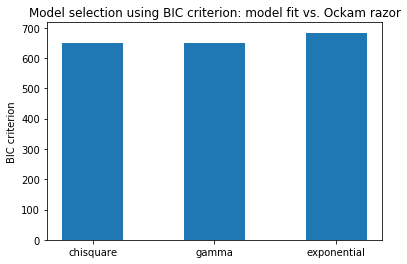

Shape parameter of the gamma distribution: 2.23241120088393
DoF of the chisquare distribution: 4.464892233492062


In [4]:
# Perform model selection using different information criteria
criteria = ['BIC', 'AIC', 'AICc']
for criterion in criteria:
    selector = InfoModelSelection(candidate_models = candidate_models, data = data, method = criterion)
    print('Sorted model using '+criterion+' criterion: '+', '.join(x for x in selector.sorted_names))
    if criterion == 'BIC':
        criterion_value = selector.sorted_criteria
        sorted_names = selector.sorted_names
        param = selector.sorted_params
        
width = 0.5
ind = np.arange(len(sorted_names))
p1 = plt.bar(ind, criterion_value, width = width)
#p2 = plt.bar(ind, criterion_value-data_fit_value, bottom=data_fit_value, width = width)

plt.ylabel('BIC criterion')
plt.title('Model selection using BIC criterion: model fit vs. Ockam razor')
plt.xticks(ind, sorted_names)
#plt.legend((p1[0], p2[0]), ('Data fit', 'Ockam razor'))

plt.show()

print('Shape parameter of the gamma distribution: {}'.format(param[sorted_names.index('gamma')][0]))
print('DoF of the chisquare distribution: {}'.format(param[sorted_names.index('chisquare')][0]))

Note that here both the chisquare and gamma are capable of explaining the data, with $a = \nu/2$, $a$ is gamma's shape parameter and $\nu$ is the number of DOFs in chi-square distribution.

## Example 2: model selection in regression -  $y=F \theta + \epsilon$

In [5]:
# Generate data from a quadratic function
from scipy.stats import multivariate_normal

param_true = np.array([1.0, 2.0]).reshape(1, -1)
error_covariance = np.eye(50)

print(param_true.shape)
z = RunModel(samples=param_true, model_script='pfn_models.py', model_object_name = 'model_quadratic', 
             var_names = ['theta_1', 'theta_2'])
data = z.qoi_list[0].reshape((-1,))+multivariate_normal.rvs(mean=None, cov=error_covariance, size=1)
print(data)

(1, 2)
[  1.51478552   1.01712706   1.21293003   0.74866982   1.77966481
   1.4852841    6.52860605   5.01150757   8.92553143   8.4926703
  10.28126011  11.07775728  15.53597031  17.54388509  19.60984425
  23.04611054  25.38581775  27.06416541  29.72579113  34.7082556
  38.42586845  41.44425518  43.98736537  48.80598474  51.91938008
  58.19087199  62.84771029  65.26369364  72.26404886  75.23155227
  81.28628779  85.32481715  92.59621551  98.41508049 104.09074933
 110.71086592 115.48469777 120.41142486 127.42708944 132.61971039
 140.71302539 149.48491884 154.94332203 160.73982926 171.37279159
 178.67040756 185.34554285 195.26286045 202.55349271 208.85035363]


In [6]:
# Create instances of the Model class for three models: linear, quadratic and cubic
names = ['linear', 'quadratic', 'cubic']
candidate_models = []
for i in range(3):
    M = Model(model_type='python', n_params=i+1,
              model_script='pfn_models.py', model_object_name = 'model_'+names[i],
              model_name=names[i], error_covariance=error_covariance)
    candidate_models.append(M)

In [7]:
# Perform model selection using BIC criterion
selector = InfoModelSelection(candidate_models = candidate_models, data = data, method = 'BIC')
print('Sorted models: ', selector.sorted_names)
print('Value of criteria: ', selector.sorted_criteria)
print('Value of penalty term (complexity)', selector.sorted_penalty_terms)
print(selector.sorted_probabilities)

(1, 1)
Optimization terminated successfully.
         Current function value: 12809.159642
         Iterations: 27
         Function evaluations: 54
(1, 2)
Optimization terminated successfully.
         Current function value: 73.563272
         Iterations: 60
         Function evaluations: 114
(1, 3)
Optimization terminated successfully.
         Current function value: 73.131679
         Iterations: 172
         Function evaluations: 311
Sorted models:  ['quadratic', 'cubic', 'linear']
Value of criteria:  [154.9505907188185, 157.9994268351627, 25622.231306708018]
Value of penalty term (complexity) [7.824046010856292, 11.736069016284437, 3.912023005428146]
[0.82118814 0.17881186 0.        ]


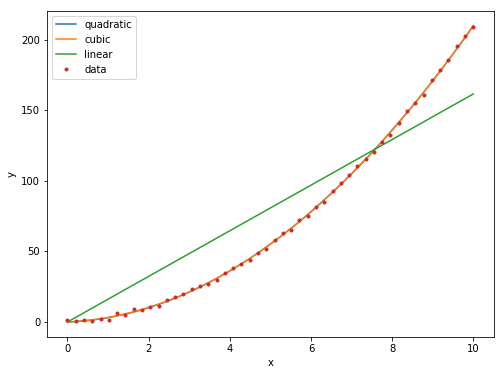

In [8]:
# Plot the results
domain = np.linspace(0, 10, 50)
fig, ax = plt.subplots(figsize=(8,6))

for i in range(3):
    var_names = ['theta {}'.format(j) for j in range(i+1)]
    z = RunModel(samples=selector.sorted_params[i].reshape((1,-1)), model_object_name = 'RunPythonModel',
                 model_script='pfn_'+selector.sorted_names[i]+'.py', var_names=var_names)
    y = z.qoi_list[0].reshape((-1,))
    ax.plot(domain, y, label = selector.sorted_names[i])

plt.plot(domain, data, linestyle='none', marker='.', label='data')
plt.xlabel('x')
plt.ylabel('y')
    
plt.legend()
plt.show()

For this case, one can observe that both the quadratic and cubic model are capable of explaining the data. The cubic model is penalized due to its higher complexity (penalty_term) and thus the quadratic model is preferred.